In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torchsummary import summary
from transformers import ViTModel, ViTConfig, ViTForImageClassification

# set the path to the directory containing the npy files
data_dir = '/home/tejasri/Desktop/eurosat-ms/multi_npy/'

# set the path to save the trained model
model_path = '/home/tejasri/Desktop/eurosat-ms/'

# load the X and y data for each class
X = []
y = []
for i in range(10):
    X_i = np.load(f'{data_dir}/X{i}.npy')
    y_i = np.load(f'{data_dir}/y{i}.npy')
    X.append(X_i)
    y.append(y_i)

# concatenate the X and y data for all classes
X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)





2023-05-30 23:13:45.220416: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 23:13:46.507681: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-30 23:13:46.508191: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-30 23:13:46.508198: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
import einops
print(X.shape)


X = einops.rearrange(X, 'b h w c -> b c h w')
              
print(X.shape)

print(X[0].shape)


(27000, 64, 64, 13)
(27000, 13, 64, 64)
(13, 64, 64)


In [3]:
from sklearn.model_selection import StratifiedShuffleSplit


# split the data into training and testing sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# split the data
for train_idx, test_idx in split.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

In [4]:
# define a custom dataset class for the EuroSAT multispectral data
class EuroSATDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# create data loaders for the training and testing sets
train_dataset = EuroSATDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = EuroSATDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# set the device to use for training and testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
print(len(train_loader))

675


In [6]:
print(len(test_loader))

169


In [7]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# Running resnet50 model

In [8]:
# Define the ResNet-50 model
model = models.resnet50(pretrained=False)
num_classes = 10
model.fc = nn.Linear(2048, num_classes)

# Modify the first convolution layer to accept 5-channel input
model.conv1 = nn.Conv2d(13, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move the model and loss function to the device
model.to(device)
criterion.to(device)

CrossEntropyLoss()

In [9]:
import torchsummary

# Print the model summary
torchsummary.summary(model.to(device), input_size=(13, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]          40,768
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]           4,096
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]          16,384
      BatchNorm2d-12          [-1, 256, 16, 16]             512
           Conv2d-13          [-1, 256, 16, 16]          16,384
      BatchNorm2d-14          [-1, 256,

In [10]:
train_losses = []
train_accu = []

def train(epoch):
    print('Epoch : %d'%epoch)
    
    model.train()
    running_loss=0
    correct=0
    total=0

    for images, labels in tqdm(train_loader):
        
        images = images.float().cuda()
        labels = labels.float().cuda()
        #print(images.size())
        #print(labels.size())
        # Forward pass
        #model = model.cuda()
        outputs = model(images)
        labels1= np.zeros((32,10))
        
        #labels1 = tensor.detach().cpu().numpy()
        for j in range(32):
            i=labels[j]
            i=int(i.item())
            # print(i)
            labels1[j][i]=1
        labels1=torch.from_numpy(labels1)
        #print(labels1.size())
        labels1=labels1.to(device='cuda')
        loss = criterion(outputs, labels1)
        
        
       # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        
    #Replaces pow(2.0) with abs() for L1 regularization
    
#     l2_lambda = 0.001
#     l2_norm = sum(p.pow(2.0).sum()
#                   for p in model.parameters())

#     loss = loss + l2_lambda * l2_norm
    
        
        running_loss += loss.item()
    
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
      
    train_loss=running_loss/len(train_loader)
    accu=100.*correct/total
  
    train_accu.append(accu)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))
    

In [11]:
eval_losses=[]
eval_accu=[]

def test(epoch):
    model.eval()

    running_loss=0
    correct=0
    total=0
    #print(test_loader)
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            
            #images = images.to(device='cuda', dtype=torch.float)
            images = images.float().cuda()
            labels = labels.float().cuda()
            #labels = labels.to(device='cuda', dtype=torch.float)
            
            # Predict classes using the model
            outputs = model(images)
            #print(labels.size())
            t,y=outputs.shape
            # print(t)
            labels1= np.zeros((t,10))
            for j in range(t):
                i=labels[j]
                i=int(i.item())
                labels1[j][i]=1
            labels1=torch.from_numpy(labels1)
            #print(labels1.size())
            labels1=labels1.to(device='cuda')
            #outputs=outputs.tensor()
            loss= criterion(outputs,labels1)
            running_loss+=loss.item()
            
            
           # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    test_loss=running_loss/len(test_loader)
    accu=100.*correct/total

    eval_losses.append(test_loss)
    eval_accu.append(accu)

    print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 
    

In [12]:
from tqdm import tqdm

In [13]:
import time
epochs = 30

# Start the timer

start_time = time.time()
for epoch in range(1,epochs+1): 
    train(epoch)
    test(epoch)
# End the timer
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

print('Training time: {:.2f} seconds'.format(training_time))


Epoch : 1


100%|█████████████████████████████████████████| 675/675 [00:27<00:00, 24.93it/s]


Train Loss: 1.025 | Accuracy: 67.630


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 75.00it/s]


Test Loss: 0.746 | Accuracy: 75.667
Epoch : 2


100%|█████████████████████████████████████████| 675/675 [00:26<00:00, 25.25it/s]


Train Loss: 0.548 | Accuracy: 82.148


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 74.02it/s]


Test Loss: 0.485 | Accuracy: 82.370
Epoch : 3


100%|█████████████████████████████████████████| 675/675 [00:26<00:00, 25.08it/s]


Train Loss: 0.423 | Accuracy: 86.287


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 75.34it/s]


Test Loss: 0.489 | Accuracy: 83.870
Epoch : 4


100%|█████████████████████████████████████████| 675/675 [00:26<00:00, 25.11it/s]


Train Loss: 0.353 | Accuracy: 88.556


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 74.97it/s]


Test Loss: 0.457 | Accuracy: 85.315
Epoch : 5


100%|█████████████████████████████████████████| 675/675 [00:27<00:00, 24.99it/s]


Train Loss: 0.418 | Accuracy: 86.713


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 66.51it/s]


Test Loss: 0.932 | Accuracy: 74.907
Epoch : 6


100%|█████████████████████████████████████████| 675/675 [00:27<00:00, 24.76it/s]


Train Loss: 0.289 | Accuracy: 90.519


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 71.00it/s]


Test Loss: 1.717 | Accuracy: 63.167
Epoch : 7


100%|█████████████████████████████████████████| 675/675 [00:26<00:00, 25.01it/s]


Train Loss: 0.259 | Accuracy: 91.468


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 72.77it/s]


Test Loss: 0.540 | Accuracy: 82.833
Epoch : 8


100%|█████████████████████████████████████████| 675/675 [00:26<00:00, 25.13it/s]


Train Loss: 0.239 | Accuracy: 92.199


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 74.38it/s]


Test Loss: 0.968 | Accuracy: 76.204
Epoch : 9


100%|█████████████████████████████████████████| 675/675 [00:26<00:00, 25.06it/s]


Train Loss: 0.226 | Accuracy: 92.713


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 72.03it/s]


Test Loss: 0.499 | Accuracy: 83.370
Epoch : 10


100%|█████████████████████████████████████████| 675/675 [00:26<00:00, 25.11it/s]


Train Loss: 0.206 | Accuracy: 93.190


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 74.74it/s]


Test Loss: 0.505 | Accuracy: 83.593
Epoch : 11


100%|█████████████████████████████████████████| 675/675 [00:26<00:00, 25.11it/s]


Train Loss: 0.205 | Accuracy: 92.963


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 73.70it/s]


Test Loss: 0.696 | Accuracy: 79.833
Epoch : 12


100%|█████████████████████████████████████████| 675/675 [00:26<00:00, 25.00it/s]


Train Loss: 0.208 | Accuracy: 93.245


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 69.28it/s]


Test Loss: 2.876 | Accuracy: 70.148
Epoch : 13


100%|█████████████████████████████████████████| 675/675 [00:27<00:00, 24.99it/s]


Train Loss: 0.202 | Accuracy: 93.676


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 74.81it/s]


Test Loss: 0.465 | Accuracy: 85.981
Epoch : 14


100%|█████████████████████████████████████████| 675/675 [00:26<00:00, 25.85it/s]


Train Loss: 0.162 | Accuracy: 94.546


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 73.89it/s]


Test Loss: 0.659 | Accuracy: 80.241
Epoch : 15


100%|█████████████████████████████████████████| 675/675 [00:26<00:00, 25.76it/s]


Train Loss: 0.160 | Accuracy: 94.792


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 73.88it/s]


Test Loss: 0.176 | Accuracy: 94.630
Epoch : 16


100%|█████████████████████████████████████████| 675/675 [00:26<00:00, 25.72it/s]


Train Loss: 0.126 | Accuracy: 95.755


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 73.57it/s]


Test Loss: 0.406 | Accuracy: 87.185
Epoch : 17


100%|█████████████████████████████████████████| 675/675 [00:26<00:00, 25.68it/s]


Train Loss: 0.115 | Accuracy: 96.093


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 71.76it/s]


Test Loss: 0.264 | Accuracy: 92.352
Epoch : 18


100%|█████████████████████████████████████████| 675/675 [00:26<00:00, 25.50it/s]


Train Loss: 0.125 | Accuracy: 96.009


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 71.45it/s]


Test Loss: 0.927 | Accuracy: 77.204
Epoch : 19


100%|█████████████████████████████████████████| 675/675 [00:26<00:00, 25.48it/s]


Train Loss: 0.107 | Accuracy: 96.259


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 72.63it/s]


Test Loss: 0.318 | Accuracy: 90.093
Epoch : 20


100%|█████████████████████████████████████████| 675/675 [00:26<00:00, 25.55it/s]


Train Loss: 0.098 | Accuracy: 96.778


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 71.70it/s]


Test Loss: 0.432 | Accuracy: 87.667
Epoch : 21


100%|█████████████████████████████████████████| 675/675 [00:26<00:00, 25.50it/s]


Train Loss: 0.096 | Accuracy: 96.981


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 72.29it/s]


Test Loss: 0.157 | Accuracy: 95.852
Epoch : 22


100%|█████████████████████████████████████████| 675/675 [00:26<00:00, 25.53it/s]


Train Loss: 0.088 | Accuracy: 97.051


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 77.48it/s]


Test Loss: 0.133 | Accuracy: 96.204
Epoch : 23


100%|█████████████████████████████████████████| 675/675 [00:26<00:00, 25.03it/s]


Train Loss: 0.095 | Accuracy: 97.000


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 77.12it/s]


Test Loss: 0.271 | Accuracy: 91.611
Epoch : 24


100%|█████████████████████████████████████████| 675/675 [00:26<00:00, 25.66it/s]


Train Loss: 0.082 | Accuracy: 97.380


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 76.66it/s]


Test Loss: 0.156 | Accuracy: 95.556
Epoch : 25


100%|█████████████████████████████████████████| 675/675 [00:26<00:00, 25.69it/s]


Train Loss: 0.077 | Accuracy: 97.486


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 78.61it/s]


Test Loss: 0.325 | Accuracy: 90.722
Epoch : 26


100%|█████████████████████████████████████████| 675/675 [00:26<00:00, 25.87it/s]


Train Loss: 0.071 | Accuracy: 97.602


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 78.55it/s]


Test Loss: 0.299 | Accuracy: 92.704
Epoch : 27


100%|█████████████████████████████████████████| 675/675 [00:26<00:00, 25.67it/s]


Train Loss: 0.068 | Accuracy: 97.574


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 73.83it/s]


Test Loss: 0.600 | Accuracy: 86.093
Epoch : 28


100%|█████████████████████████████████████████| 675/675 [00:27<00:00, 24.93it/s]


Train Loss: 0.057 | Accuracy: 98.079


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 72.36it/s]


Test Loss: 0.244 | Accuracy: 93.611
Epoch : 29


100%|█████████████████████████████████████████| 675/675 [00:26<00:00, 25.70it/s]


Train Loss: 0.055 | Accuracy: 98.231


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 73.52it/s]


Test Loss: 0.221 | Accuracy: 94.019
Epoch : 30


100%|█████████████████████████████████████████| 675/675 [00:26<00:00, 25.61it/s]


Train Loss: 0.061 | Accuracy: 98.069


100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 72.62it/s]

Test Loss: 0.418 | Accuracy: 91.130
Training time: 868.23 seconds


In [14]:
import matplotlib.pyplot as plt


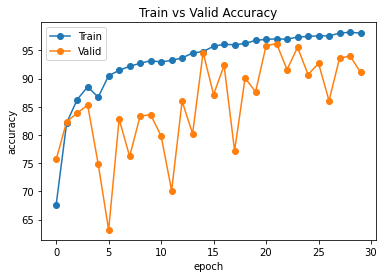

In [15]:
#plot accuracy
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

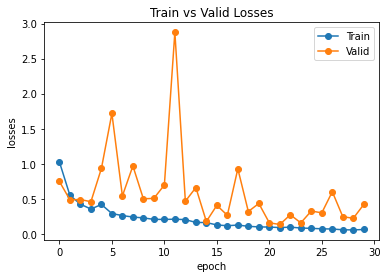

In [16]:
#plot losses

plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [17]:
from sklearn.metrics import confusion_matrix ,classification_report, precision_score, recall_score

# testing
ttloss = []
ttacc = []
ttf1 = []

T_val = []
P_val = []

with torch.no_grad():
    model.eval()
    for (X_val, y_val) in tqdm(test_loader):
        X_val = X_val.float().cuda()
        y_val = y_val.float().cuda()
        #X_val, y_val = X_val.to(device), y_val.to(device)
        #y_val = y_val.type(torch.cuda.LongTensor)
        
        output = model(X_val)
        #print(output.shape)
        
        outputs = torch.max(output, dim=1)[1]
        #print(outputs.shape)
        T_val.extend(y_val.cpu().numpy())
        #print(T_val)
        P_val.extend(outputs.cpu().numpy())
    #print(T_val)
    #print(P_val)
    precision = precision_score(T_val, P_val, average='macro')
    recall = recall_score(T_val, P_val, average='macro')
    res = confusion_matrix(T_val, P_val)
    report = classification_report(T_val, P_val)
    
    print("Precision: ",precision)
    print("Recall: ",recall)

    print('Confusion matrix:\n',res)
    print('Report:\n',report)

100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 73.67it/s]


Precision:  0.9285208437069683
Recall:  0.9049666666666667
Confusion matrix:
 [[546   0   5   6   1   4  30   8   0   0]
 [  2 580   8   0   0   5   0   5   0   0]
 [  0   0 570   1   0   1   5  20   3   0]
 [  4   0   2 413   5   2   7  61   6   0]
 [  0   0   0   9 390   0   1 100   0   0]
 [  7   1  28   0   0 340   8  16   0   0]
 [ 10   1   9   2   1   0 406  70   1   0]
 [  0   0   0   0   2   0   0 598   0   0]
 [  4   1   2   1   1   2   0   4 485   0]
 [  0   0   0   0   0   0   0   0   7 593]]
Report:
               precision    recall  f1-score   support

         0.0       0.95      0.91      0.93       600
         1.0       0.99      0.97      0.98       600
         2.0       0.91      0.95      0.93       600
         3.0       0.96      0.83      0.89       500
         4.0       0.97      0.78      0.87       500
         5.0       0.96      0.85      0.90       400
         6.0       0.89      0.81      0.85       500
         7.0       0.68      1.00      0.81      

# Running resnet101 model

In [18]:
# Define the ResNet-50 model
model = models.resnet101(pretrained=True)
num_classes = 10
model.fc = nn.Linear(2048, num_classes)

# Modify the first convolution layer to accept 5-channel input
model.conv1 = nn.Conv2d(13, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move the model and loss function to the device
model.to(device)
criterion.to(device)

CrossEntropyLoss()

In [19]:
import torchsummary

# Print the model summary
torchsummary.summary(model.to(device), input_size=(13, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]          40,768
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]           4,096
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]          16,384
      BatchNorm2d-12          [-1, 256, 16, 16]             512
           Conv2d-13          [-1, 256, 16, 16]          16,384
      BatchNorm2d-14          [-1, 256,

In [20]:
train_losses = []
train_accu = []

def train(epoch):
    print('Epoch : %d'%epoch)
    
    model.train()
    running_loss=0
    correct=0
    total=0

    for images, labels in tqdm(train_loader):
        
        images = images.float().cuda()
        labels = labels.float().cuda()
        #print(images.size())
        #print(labels.size())
        # Forward pass
        #model = model.cuda()
        outputs = model(images)
        labels1= np.zeros((32,10))
        
        #labels1 = tensor.detach().cpu().numpy()
        for j in range(32):
            i=labels[j]
            i=int(i.item())
            # print(i)
            labels1[j][i]=1
        labels1=torch.from_numpy(labels1)
        #print(labels1.size())
        labels1=labels1.to(device='cuda')
        loss = criterion(outputs, labels1)
        
        
       # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        
    #Replaces pow(2.0) with abs() for L1 regularization
    
#     l2_lambda = 0.001
#     l2_norm = sum(p.pow(2.0).sum()
#                   for p in model.parameters())

#     loss = loss + l2_lambda * l2_norm
    
        
        running_loss += loss.item()
    
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
      
    train_loss=running_loss/len(train_loader)
    accu=100.*correct/total
  
    train_accu.append(accu)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))
    

In [21]:
eval_losses=[]
eval_accu=[]

def test(epoch):
    model.eval()

    running_loss=0
    correct=0
    total=0
    #print(test_loader)
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            
            #images = images.to(device='cuda', dtype=torch.float)
            images = images.float().cuda()
            labels = labels.float().cuda()
            #labels = labels.to(device='cuda', dtype=torch.float)
            
            # Predict classes using the model
            outputs = model(images)
            #print(labels.size())
            t,y=outputs.shape
            # print(t)
            labels1= np.zeros((t,10))
            for j in range(t):
                i=labels[j]
                i=int(i.item())
                labels1[j][i]=1
            labels1=torch.from_numpy(labels1)
            #print(labels1.size())
            labels1=labels1.to(device='cuda')
            #outputs=outputs.tensor()
            loss= criterion(outputs,labels1)
            running_loss+=loss.item()
            
            
           # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    test_loss=running_loss/len(test_loader)
    accu=100.*correct/total

    eval_losses.append(test_loss)
    eval_accu.append(accu)

    print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 
    

In [22]:
from tqdm import tqdm

In [23]:
import time
epochs = 30

# Start the timer

start_time = time.time()
for epoch in range(1,epochs+1): 
    train(epoch)
    test(epoch)
# End the timer
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

print('Training time: {:.2f} seconds'.format(training_time))


Epoch : 1


100%|█████████████████████████████████████████| 675/675 [00:44<00:00, 15.32it/s]


Train Loss: 0.690 | Accuracy: 77.903


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 48.69it/s]


Test Loss: 0.382 | Accuracy: 87.296
Epoch : 2


100%|█████████████████████████████████████████| 675/675 [00:44<00:00, 15.21it/s]


Train Loss: 0.381 | Accuracy: 87.324


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 46.66it/s]


Test Loss: 0.276 | Accuracy: 90.759
Epoch : 3


100%|█████████████████████████████████████████| 675/675 [00:44<00:00, 15.19it/s]


Train Loss: 0.263 | Accuracy: 91.167


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 47.47it/s]


Test Loss: 0.819 | Accuracy: 75.815
Epoch : 4


100%|█████████████████████████████████████████| 675/675 [00:44<00:00, 15.23it/s]


Train Loss: 0.282 | Accuracy: 90.847


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 47.82it/s]


Test Loss: 0.306 | Accuracy: 90.241
Epoch : 5


100%|█████████████████████████████████████████| 675/675 [00:44<00:00, 15.28it/s]


Train Loss: 0.224 | Accuracy: 92.477


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 48.22it/s]


Test Loss: 1.629 | Accuracy: 75.093
Epoch : 6


100%|█████████████████████████████████████████| 675/675 [00:44<00:00, 15.26it/s]


Train Loss: 0.258 | Accuracy: 91.528


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 48.31it/s]


Test Loss: 0.198 | Accuracy: 93.926
Epoch : 7


100%|█████████████████████████████████████████| 675/675 [00:44<00:00, 15.24it/s]


Train Loss: 0.170 | Accuracy: 94.491


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 51.54it/s]


Test Loss: 0.280 | Accuracy: 91.593
Epoch : 8


100%|█████████████████████████████████████████| 675/675 [00:42<00:00, 15.74it/s]


Train Loss: 0.145 | Accuracy: 95.046


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 50.38it/s]


Test Loss: 0.171 | Accuracy: 94.815
Epoch : 9


100%|█████████████████████████████████████████| 675/675 [00:44<00:00, 15.10it/s]


Train Loss: 0.139 | Accuracy: 95.255


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 48.76it/s]


Test Loss: 0.418 | Accuracy: 87.167
Epoch : 10


100%|█████████████████████████████████████████| 675/675 [00:44<00:00, 15.27it/s]


Train Loss: 0.114 | Accuracy: 96.079


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 47.93it/s]


Test Loss: 0.181 | Accuracy: 94.389
Epoch : 11


100%|█████████████████████████████████████████| 675/675 [00:44<00:00, 15.23it/s]


Train Loss: 0.114 | Accuracy: 96.079


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 47.83it/s]


Test Loss: 0.530 | Accuracy: 87.463
Epoch : 12


100%|█████████████████████████████████████████| 675/675 [00:44<00:00, 15.14it/s]


Train Loss: 0.088 | Accuracy: 97.065


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 47.85it/s]


Test Loss: 0.223 | Accuracy: 93.278
Epoch : 13


100%|█████████████████████████████████████████| 675/675 [00:44<00:00, 15.12it/s]


Train Loss: 0.082 | Accuracy: 97.139


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 49.10it/s]


Test Loss: 0.226 | Accuracy: 92.463
Epoch : 14


100%|█████████████████████████████████████████| 675/675 [00:43<00:00, 15.61it/s]


Train Loss: 0.082 | Accuracy: 97.194


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 49.40it/s]


Test Loss: 0.210 | Accuracy: 93.611
Epoch : 15


100%|█████████████████████████████████████████| 675/675 [00:43<00:00, 15.36it/s]


Train Loss: 0.080 | Accuracy: 97.361


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 50.46it/s]


Test Loss: 0.253 | Accuracy: 92.259
Epoch : 16


100%|█████████████████████████████████████████| 675/675 [00:43<00:00, 15.65it/s]


Train Loss: 0.061 | Accuracy: 97.833


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 50.40it/s]


Test Loss: 0.199 | Accuracy: 94.056
Epoch : 17


100%|█████████████████████████████████████████| 675/675 [00:43<00:00, 15.40it/s]


Train Loss: 0.076 | Accuracy: 97.560


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 47.29it/s]


Test Loss: 0.214 | Accuracy: 94.259
Epoch : 18


100%|█████████████████████████████████████████| 675/675 [00:43<00:00, 15.53it/s]


Train Loss: 0.065 | Accuracy: 98.032


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 50.54it/s]


Test Loss: 0.215 | Accuracy: 94.241
Epoch : 19


100%|█████████████████████████████████████████| 675/675 [00:43<00:00, 15.55it/s]


Train Loss: 0.045 | Accuracy: 98.361


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 49.56it/s]


Test Loss: 0.243 | Accuracy: 93.037
Epoch : 20


100%|█████████████████████████████████████████| 675/675 [00:43<00:00, 15.51it/s]


Train Loss: 0.059 | Accuracy: 98.046


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 46.82it/s]


Test Loss: 0.158 | Accuracy: 95.407
Epoch : 21


100%|█████████████████████████████████████████| 675/675 [00:43<00:00, 15.54it/s]


Train Loss: 0.045 | Accuracy: 98.509


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 48.92it/s]


Test Loss: 0.295 | Accuracy: 92.315
Epoch : 22


100%|█████████████████████████████████████████| 675/675 [00:43<00:00, 15.53it/s]


Train Loss: 0.042 | Accuracy: 98.574


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 48.84it/s]


Test Loss: 0.296 | Accuracy: 92.611
Epoch : 23


100%|█████████████████████████████████████████| 675/675 [00:43<00:00, 15.52it/s]


Train Loss: 0.042 | Accuracy: 98.625


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 48.83it/s]


Test Loss: 0.168 | Accuracy: 95.519
Epoch : 24


100%|█████████████████████████████████████████| 675/675 [00:43<00:00, 15.57it/s]


Train Loss: 0.038 | Accuracy: 98.653


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 48.76it/s]


Test Loss: 0.155 | Accuracy: 95.630
Epoch : 25


100%|█████████████████████████████████████████| 675/675 [00:43<00:00, 15.56it/s]


Train Loss: 0.036 | Accuracy: 98.764


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 49.40it/s]


Test Loss: 0.462 | Accuracy: 90.870
Epoch : 26


100%|█████████████████████████████████████████| 675/675 [00:43<00:00, 15.62it/s]


Train Loss: 0.042 | Accuracy: 98.616


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 49.10it/s]


Test Loss: 0.252 | Accuracy: 93.315
Epoch : 27


100%|█████████████████████████████████████████| 675/675 [00:43<00:00, 15.56it/s]


Train Loss: 0.033 | Accuracy: 98.884


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 48.71it/s]


Test Loss: 0.165 | Accuracy: 95.852
Epoch : 28


100%|█████████████████████████████████████████| 675/675 [00:43<00:00, 15.46it/s]


Train Loss: 0.032 | Accuracy: 98.921


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 49.59it/s]


Test Loss: 0.214 | Accuracy: 94.704
Epoch : 29


100%|█████████████████████████████████████████| 675/675 [00:43<00:00, 15.49it/s]


Train Loss: 0.035 | Accuracy: 98.856


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 49.01it/s]


Test Loss: 0.138 | Accuracy: 96.426
Epoch : 30


100%|█████████████████████████████████████████| 675/675 [00:43<00:00, 15.55it/s]


Train Loss: 0.033 | Accuracy: 98.870


100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 49.15it/s]

Test Loss: 0.218 | Accuracy: 95.296
Training time: 1418.04 seconds


In [24]:
import matplotlib.pyplot as plt


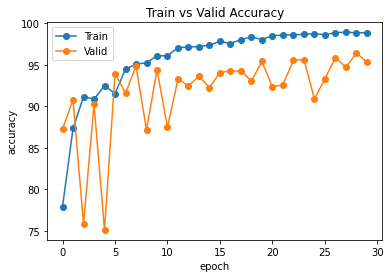

In [25]:
#plot accuracy
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

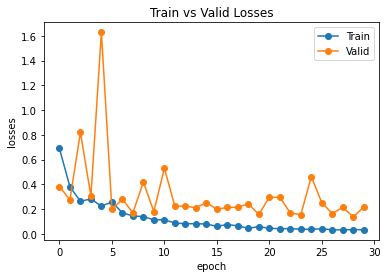

In [26]:
#plot losses

plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [27]:
from sklearn.metrics import confusion_matrix ,classification_report, precision_score, recall_score

# testing
ttloss = []
ttacc = []
ttf1 = []

T_val = []
P_val = []

with torch.no_grad():
    model.eval()
    for (X_val, y_val) in tqdm(test_loader):
        X_val = X_val.float().cuda()
        y_val = y_val.float().cuda()
        #X_val, y_val = X_val.to(device), y_val.to(device)
        #y_val = y_val.type(torch.cuda.LongTensor)
        
        output = model(X_val)
        #print(output.shape)
        
        outputs = torch.max(output, dim=1)[1]
        #print(outputs.shape)
        T_val.extend(y_val.cpu().numpy())
        #print(T_val)
        P_val.extend(outputs.cpu().numpy())
    #print(T_val)
    #print(P_val)
    precision = precision_score(T_val, P_val, average='macro')
    recall = recall_score(T_val, P_val, average='macro')
    res = confusion_matrix(T_val, P_val)
    report = classification_report(T_val, P_val)
    
    print("Precision: ",precision)
    print("Recall: ",recall)

    print('Confusion matrix:\n',res)
    print('Report:\n',report)

100%|█████████████████████████████████████████| 169/169 [00:03<00:00, 47.57it/s]

Precision:  0.9519213553148358
Recall:  0.9523833333333332
Confusion matrix:
 [[580   6   3   1   0   8   2   0   0   0]
 [  0 593   4   0   0   2   0   0   1   0]
 [  1  13 548   1   1  18   6   1   9   2]
 [  7   0   1 452  23   5   3   1   8   0]
 [  0   0   0   3 495   0   0   2   0   0]
 [  2   9   5   0   0 383   1   0   0   0]
 [ 26   1  17   1   0   5 448   0   2   0]
 [  1   0   0   2  27   0  10 560   0   0]
 [  3   1   0   5   0   2   0   0 489   0]
 [  0   0   0   0   0   0   0   0   2 598]]
Report:
               precision    recall  f1-score   support

         0.0       0.94      0.97      0.95       600
         1.0       0.95      0.99      0.97       600
         2.0       0.95      0.91      0.93       600
         3.0       0.97      0.90      0.94       500
         4.0       0.91      0.99      0.95       500
         5.0       0.91      0.96      0.93       400
         6.0       0.95      0.90      0.92       500
         7.0       0.99      0.93      0.96      

# Running resnet152 model

In [28]:
# Define the ResNet-152 model
model = models.resnet152(pretrained=True)
num_classes = 10
model.fc = nn.Linear(2048, num_classes)

# Modify the first convolution layer to accept 5-channel input
model.conv1 = nn.Conv2d(13, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move the model and loss function to the device
model.to(device)
criterion.to(device)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /home/tejasri/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

CrossEntropyLoss()

In [29]:
import torchsummary

# Print the model summary
torchsummary.summary(model.to(device), input_size=(13, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]          40,768
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]           4,096
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]          16,384
      BatchNorm2d-12          [-1, 256, 16, 16]             512
           Conv2d-13          [-1, 256, 16, 16]          16,384
      BatchNorm2d-14          [-1, 256,

In [30]:
train_losses = []
train_accu = []

def train(epoch):
    print('Epoch : %d'%epoch)
    
    model.train()
    running_loss=0
    correct=0
    total=0

    for images, labels in tqdm(train_loader):
        
        images = images.float().cuda()
        labels = labels.float().cuda()
        #print(images.size())
        #print(labels.size())
        # Forward pass
        #model = model.cuda()
        outputs = model(images)
        labels1= np.zeros((32,10))
        
        #labels1 = tensor.detach().cpu().numpy()
        for j in range(32):
            i=labels[j]
            i=int(i.item())
            # print(i)
            labels1[j][i]=1
        labels1=torch.from_numpy(labels1)
        #print(labels1.size())
        labels1=labels1.to(device='cuda')
        loss = criterion(outputs, labels1)
        
        
       # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        
    #Replaces pow(2.0) with abs() for L1 regularization
    
#     l2_lambda = 0.001
#     l2_norm = sum(p.pow(2.0).sum()
#                   for p in model.parameters())

#     loss = loss + l2_lambda * l2_norm
    
        
        running_loss += loss.item()
    
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
      
    train_loss=running_loss/len(train_loader)
    accu=100.*correct/total
  
    train_accu.append(accu)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))
    

In [31]:
eval_losses=[]
eval_accu=[]

def test(epoch):
    model.eval()

    running_loss=0
    correct=0
    total=0
    #print(test_loader)
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            
            #images = images.to(device='cuda', dtype=torch.float)
            images = images.float().cuda()
            labels = labels.float().cuda()
            #labels = labels.to(device='cuda', dtype=torch.float)
            
            # Predict classes using the model
            outputs = model(images)
            #print(labels.size())
            t,y=outputs.shape
            # print(t)
            labels1= np.zeros((t,10))
            for j in range(t):
                i=labels[j]
                i=int(i.item())
                labels1[j][i]=1
            labels1=torch.from_numpy(labels1)
            #print(labels1.size())
            labels1=labels1.to(device='cuda')
            #outputs=outputs.tensor()
            loss= criterion(outputs,labels1)
            running_loss+=loss.item()
            
            
           # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    test_loss=running_loss/len(test_loader)
    accu=100.*correct/total

    eval_losses.append(test_loss)
    eval_accu.append(accu)

    print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 
    

In [32]:
from tqdm import tqdm

In [33]:
import time
epochs = 30

# Start the timer

start_time = time.time()
for epoch in range(1,epochs+1): 
    train(epoch)
    test(epoch)
# End the timer
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

print('Training time: {:.2f} seconds'.format(training_time))


Epoch : 1


100%|█████████████████████████████████████████| 675/675 [01:00<00:00, 11.16it/s]


Train Loss: 0.746 | Accuracy: 76.394


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 36.13it/s]


Test Loss: 4.897 | Accuracy: 69.259
Epoch : 2


100%|█████████████████████████████████████████| 675/675 [01:00<00:00, 11.09it/s]


Train Loss: 0.446 | Accuracy: 85.157


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 35.71it/s]


Test Loss: 0.309 | Accuracy: 90.241
Epoch : 3


100%|█████████████████████████████████████████| 675/675 [01:00<00:00, 11.14it/s]


Train Loss: 0.311 | Accuracy: 89.745


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 36.17it/s]


Test Loss: 0.377 | Accuracy: 88.222
Epoch : 4


100%|█████████████████████████████████████████| 675/675 [01:00<00:00, 11.09it/s]


Train Loss: 0.243 | Accuracy: 91.926


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 36.28it/s]


Test Loss: 0.249 | Accuracy: 91.648
Epoch : 5


100%|█████████████████████████████████████████| 675/675 [01:01<00:00, 11.03it/s]


Train Loss: 0.235 | Accuracy: 92.134


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 37.45it/s]


Test Loss: 0.268 | Accuracy: 91.278
Epoch : 6


100%|█████████████████████████████████████████| 675/675 [00:59<00:00, 11.31it/s]


Train Loss: 0.183 | Accuracy: 93.810


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 37.43it/s]


Test Loss: 0.225 | Accuracy: 92.481
Epoch : 7


100%|█████████████████████████████████████████| 675/675 [00:59<00:00, 11.33it/s]


Train Loss: 0.178 | Accuracy: 94.120


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 37.47it/s]


Test Loss: 0.269 | Accuracy: 91.685
Epoch : 8


100%|█████████████████████████████████████████| 675/675 [00:59<00:00, 11.31it/s]


Train Loss: 0.153 | Accuracy: 94.870


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 37.49it/s]


Test Loss: 0.501 | Accuracy: 85.556
Epoch : 9


100%|█████████████████████████████████████████| 675/675 [00:59<00:00, 11.32it/s]


Train Loss: 0.132 | Accuracy: 95.486


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 37.96it/s]


Test Loss: 0.418 | Accuracy: 86.667
Epoch : 10


100%|█████████████████████████████████████████| 675/675 [00:59<00:00, 11.31it/s]


Train Loss: 0.122 | Accuracy: 95.764


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 38.21it/s]


Test Loss: 0.216 | Accuracy: 93.722
Epoch : 11


100%|█████████████████████████████████████████| 675/675 [00:59<00:00, 11.36it/s]


Train Loss: 0.109 | Accuracy: 96.403


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 38.04it/s]


Test Loss: 0.238 | Accuracy: 92.611
Epoch : 12


100%|█████████████████████████████████████████| 675/675 [00:59<00:00, 11.28it/s]


Train Loss: 0.104 | Accuracy: 96.398


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 37.38it/s]


Test Loss: 0.168 | Accuracy: 95.296
Epoch : 13


100%|█████████████████████████████████████████| 675/675 [00:59<00:00, 11.30it/s]


Train Loss: 0.087 | Accuracy: 97.023


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 38.10it/s]


Test Loss: 0.165 | Accuracy: 94.963
Epoch : 14


100%|█████████████████████████████████████████| 675/675 [00:59<00:00, 11.34it/s]


Train Loss: 0.089 | Accuracy: 97.079


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 37.99it/s]


Test Loss: 0.602 | Accuracy: 90.407
Epoch : 15


100%|█████████████████████████████████████████| 675/675 [00:59<00:00, 11.30it/s]


Train Loss: 0.078 | Accuracy: 97.361


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 37.87it/s]


Test Loss: 0.447 | Accuracy: 92.093
Epoch : 16


100%|█████████████████████████████████████████| 675/675 [00:59<00:00, 11.30it/s]


Train Loss: 0.076 | Accuracy: 97.505


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 37.92it/s]


Test Loss: 0.141 | Accuracy: 96.111
Epoch : 17


100%|█████████████████████████████████████████| 675/675 [00:59<00:00, 11.31it/s]


Train Loss: 0.064 | Accuracy: 97.875


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 37.39it/s]


Test Loss: 0.208 | Accuracy: 93.926
Epoch : 18


100%|█████████████████████████████████████████| 675/675 [00:59<00:00, 11.27it/s]


Train Loss: 0.061 | Accuracy: 97.912


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 37.37it/s]


Test Loss: 0.162 | Accuracy: 95.537
Epoch : 19


100%|█████████████████████████████████████████| 675/675 [00:59<00:00, 11.27it/s]


Train Loss: 0.058 | Accuracy: 97.968


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 37.93it/s]


Test Loss: 0.163 | Accuracy: 95.407
Epoch : 20


100%|█████████████████████████████████████████| 675/675 [00:59<00:00, 11.32it/s]


Train Loss: 0.060 | Accuracy: 98.023


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 37.81it/s]


Test Loss: 0.172 | Accuracy: 95.093
Epoch : 21


100%|█████████████████████████████████████████| 675/675 [00:59<00:00, 11.28it/s]


Train Loss: 0.043 | Accuracy: 98.542


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 37.35it/s]


Test Loss: 0.148 | Accuracy: 95.796
Epoch : 22


100%|█████████████████████████████████████████| 675/675 [01:00<00:00, 11.13it/s]


Train Loss: 0.051 | Accuracy: 98.296


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 35.94it/s]


Test Loss: 0.205 | Accuracy: 94.593
Epoch : 23


100%|█████████████████████████████████████████| 675/675 [00:59<00:00, 11.26it/s]


Train Loss: 0.038 | Accuracy: 98.625


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 37.09it/s]


Test Loss: 0.343 | Accuracy: 91.241
Epoch : 24


100%|█████████████████████████████████████████| 675/675 [00:59<00:00, 11.26it/s]


Train Loss: 0.043 | Accuracy: 98.593


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 36.47it/s]


Test Loss: 0.129 | Accuracy: 96.556
Epoch : 25


100%|█████████████████████████████████████████| 675/675 [01:00<00:00, 11.20it/s]


Train Loss: 0.037 | Accuracy: 98.755


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 37.43it/s]


Test Loss: 0.201 | Accuracy: 95.037
Epoch : 26


100%|█████████████████████████████████████████| 675/675 [00:59<00:00, 11.27it/s]


Train Loss: 0.052 | Accuracy: 98.259


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 37.09it/s]


Test Loss: 0.229 | Accuracy: 94.315
Epoch : 27


100%|█████████████████████████████████████████| 675/675 [01:00<00:00, 11.20it/s]


Train Loss: 0.044 | Accuracy: 98.551


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 37.72it/s]


Test Loss: 0.125 | Accuracy: 96.870
Epoch : 28


100%|█████████████████████████████████████████| 675/675 [01:00<00:00, 11.24it/s]


Train Loss: 0.030 | Accuracy: 99.023


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 38.02it/s]


Test Loss: 0.235 | Accuracy: 93.796
Epoch : 29


100%|█████████████████████████████████████████| 675/675 [00:59<00:00, 11.31it/s]


Train Loss: 0.035 | Accuracy: 98.856


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 37.57it/s]


Test Loss: 0.158 | Accuracy: 95.963
Epoch : 30


100%|█████████████████████████████████████████| 675/675 [00:59<00:00, 11.28it/s]


Train Loss: 0.026 | Accuracy: 99.120


100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 37.99it/s]

Test Loss: 0.147 | Accuracy: 96.630
Training time: 1935.55 seconds


In [34]:
import matplotlib.pyplot as plt


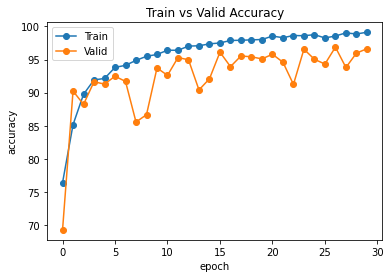

In [35]:
#plot accuracy
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

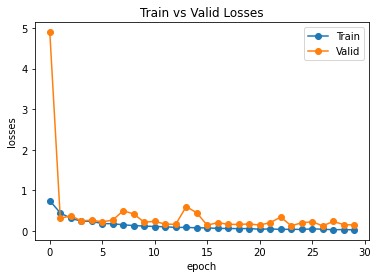

In [36]:
#plot losses

plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [37]:
from sklearn.metrics import confusion_matrix ,classification_report, precision_score, recall_score

# testing
ttloss = []
ttacc = []
ttf1 = []

T_val = []
P_val = []

with torch.no_grad():
    model.eval()
    for (X_val, y_val) in tqdm(test_loader):
        X_val = X_val.float().cuda()
        y_val = y_val.float().cuda()
        #X_val, y_val = X_val.to(device), y_val.to(device)
        #y_val = y_val.type(torch.cuda.LongTensor)
        
        output = model(X_val)
        #print(output.shape)
        
        outputs = torch.max(output, dim=1)[1]
        #print(outputs.shape)
        T_val.extend(y_val.cpu().numpy())
        #print(T_val)
        P_val.extend(outputs.cpu().numpy())
    #print(T_val)
    #print(P_val)
    precision = precision_score(T_val, P_val, average='macro')
    recall = recall_score(T_val, P_val, average='macro')
    res = confusion_matrix(T_val, P_val)
    report = classification_report(T_val, P_val)
    
    print("Precision: ",precision)
    print("Recall: ",recall)

    print('Confusion matrix:\n',res)
    print('Report:\n',report)

100%|█████████████████████████████████████████| 169/169 [00:04<00:00, 36.22it/s]

Precision:  0.9654977353412038
Recall:  0.9651
Confusion matrix:
 [[570   2   6   1   0  11  10   0   0   0]
 [  0 589   8   0   0   3   0   0   0   0]
 [  1   2 584   0   0   9   4   0   0   0]
 [  2   0   1 468   9   8   2   7   3   0]
 [  0   0   0   0 483   0   0  17   0   0]
 [  5   1   7   0   0 382   5   0   0   0]
 [  8   0  18   2   0   1 470   0   1   0]
 [  0   0   1   0   5   0   6 588   0   0]
 [  3   1   1   4   0   2   0   1 487   1]
 [  0   0   0   0   0   0   0   0   3 597]]
Report:
               precision    recall  f1-score   support

         0.0       0.97      0.95      0.96       600
         1.0       0.99      0.98      0.99       600
         2.0       0.93      0.97      0.95       600
         3.0       0.99      0.94      0.96       500
         4.0       0.97      0.97      0.97       500
         5.0       0.92      0.95      0.94       400
         6.0       0.95      0.94      0.94       500
         7.0       0.96      0.98      0.97       600
       